<a target="_blank" href="https://colab.research.google.com/github/alejandrogtz/cccs630-fall2023/blob/main/module03/agent-based_introduction.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Introduction to Agent-Based Simulators

## Introduction

Now that we have covered two cellular automata in the course, we will continue to increase the sophistication and complexity of our models and simulations.

In this module, we will add the concepts of agents and interactions to our knowledge. Agents are individual entities that have specific properties, behaviours, rules, and decision-making capabilities. They interact with each other and with their environment to produce complex, often emergent, phenomena. The objective of creating agent-based simulations is to study how the actions and interactions of agents lead to collective outcomes at the system level.

Please review the following article from the news about the gentrification problem a neighbourhood in Toronto faced in 2020 in preparation for the module.

https://www.theguardian.com/cities/2020/jan/14/my-parkdale-is-gone-how-gentrification-reached-the-one-place-that-seemed-immune

## Concepts

You will find a list of important concepts we will review in the module below.

- Agent-based models
- Agents
- Environments
- Interactions
- Schelling's model
- Segregation models

## Interaction

In the context of agent-based models, an agent is "an autonomous entity, having the ability to decide the actions to be carried out in the environment and interactions to be established with other agents, according to its perceptions and internal state" (Franklin & Graesser, 1997). 

Agents can represent anything from individuals, companies, and animals to cells, particles, vehicles, or even countries, depending on the scale and purpose of the simulation.

As the definition points out, agents do not function in isolation. They interact with each other and with their environment. These interactions can vary depending on the system we are trying to model; for example, agents can follow defined rules and behaviours, have interactions mediated by the environment, or require a communication language for the agents to exchange information. 

Agents operate in a digital environment that provides them with the conditions to exist and arbitrate the interaction between agents and access to resources.

In this module, we will study our first agent-based model, Schelling's segregation model. The model was created by the American economist Thomas Schelling in the 1970s.

The model has two types of agents, agent types A and B, that operate on a two-dimensional grid (similar to Conway's cellular automata). Each cell of the grid can be in one of three states:

- Occupied by an agent type 1, and shown in red in the simulation.
- Occupied by an agent type 2, and shown in blue in the simulation.
- Unoccupied or vacant, represented by a zero and shown in white on the grid.

With these three states, for example, the initial conditions would look like the following image for a 5 x 5 grid.

<img src="https://drive.google.com/uc?export=view&id=1bGUkcSTB6Y9cCKXNt3T4-gGZ3_Q0nVTH" width="300" />

Each agent, whether type 1 or 2, has a preference regarding the type of neighbours they want to be surrounded by. An agent wants at least a certain fraction of its neighbours to be of the same type. If this preference is not met, the agent is considered "unhappy" and will want to move. In each discrete cycle, all unhappy agents are first identified and then transferred to a vacant location randomly assigned.

Schelling's model explains how small preferences for one's neighbours to be of the same type can lead to large-scale patterns of segregation, even when individuals do not have an intrinsic or strong preference to be separated from others.

### Instructions

- Simulate the following tolerance thresholds for the agents:
    - High tolerance, threshold < 0.2
    - Average tolerance, threshold >= 0.2 and threshold <= 0.7
    - Low tolerance, threshold > 0.7
- Analyze the patterns that emerge on the grid.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib import animation, rc, colors

rc('animation', html='html5')

In [4]:
# Function to create a grid with randomly allocated agents.
# This grid is the digital environment where agents operate.
# On the grid: 0 = empty (white), 1 = agent type 1 (red), 2 = agent type 2 (blue)
def initialize_grid(grid_size, minority_ratio):    
    grid = np.random.choice([0, 1, 2], size=(grid_size, grid_size), p=[1 - minority_ratio, minority_ratio / 2, minority_ratio / 2])
    return grid

In [5]:
# Function to count the number of similar neighbors.
def count_neighbors(grid, axis_0, axis_1, agent_type, radius=1):
    neighbors = grid[max(0, axis_0 - radius): min(axis_0 + radius + 1, grid.shape[0]),
                     max(0, axis_1 - radius): min(axis_1 + radius + 1, grid.shape[1])]
    return np.count_nonzero(neighbors == agent_type)

In [6]:
# Function to determine the average happiness level and the percentage of happy agents on the grid.
def calculate_grid_happiness(grid_history,threshold):
    grid_happiness_level = []
    grid_happy_agents = []

    for grid in grid_history:
        
        total_agents = len(np.argwhere(grid >= 1)) # Number of agents type 1 and above.
        
        agents_happiness_level = []
        count_happy_agents = 0
        for axis_0 in range(grid.shape[0]):
            for axis_1 in range(grid.shape[1]):
                if grid[axis_0, axis_1]>0: # Ignore vacant spaces.
                    happiness_level = calculate_happiness(grid,axis_0,axis_1)
                    agents_happiness_level.append(happiness_level)
                    if (happiness_level>=threshold):
                        count_happy_agents += 1
                        
        grid_happiness_level.append(sum(agents_happiness_level)/len(agents_happiness_level))
        grid_happy_agents.append(count_happy_agents/total_agents)
    
    return (grid_happiness_level,grid_happy_agents)

In [7]:
# Function to determine the happiness level of a cell.
def calculate_happiness(grid, axis_0, axis_1, radius=1):
    agent_type = grid[axis_0, axis_1] # Agent type of the cell.
    
    agent_types = [1 , 2]
    agent_types.remove(agent_type)
     
    different_neighbors = count_neighbors(grid, axis_0, axis_1, agent_types.pop(0), radius) # Count number neighbors of different type.
    
    similar_neighbors = count_neighbors(grid, axis_0, axis_1, agent_type, radius) - 1  # Count excludes the agent itself.

    total_neighbors = similar_neighbors + different_neighbors
    
    if total_neighbors == 0:
        return 0
    
    return similar_neighbors / total_neighbors

In [8]:
def identify_unhappy_agents(grid, threshold, radius=1):
    unhappy_agents = []
    for axis_0 in range(grid.shape[0]):
        for axis_1 in range(grid.shape[1]):
            if grid[axis_0, axis_1]>0:
                if (calculate_happiness(grid, axis_0, axis_1, radius)<threshold):
                    unhappy_agents.append([axis_0,axis_1])
    return(unhappy_agents)

In [9]:
def move_unhappy_agents(grid, unhappy_agents, threshold, radius=1):
    new_grid = grid.copy()
    for unhappy_agent in unhappy_agents:
        axis_0, axis_1 = unhappy_agent
        empty_spaces = np.argwhere(new_grid == 0)
        if len(empty_spaces) > 0:
            np.random.shuffle(empty_spaces)
            new_axis_0, new_axis_1 = empty_spaces[0]
            new_grid[new_axis_0, new_axis_1] = grid[axis_0, axis_1]
            new_grid[axis_0, axis_1] = 0
    return new_grid  

In [10]:
# Function to debug the code. The function shows a single grid.
def visualize_grid(grid): 
    custom_cmap = colors.LinearSegmentedColormap.from_list("", ["white","red","blue"])
    plt.imshow(grid, cmap=custom_cmap, vmin=0, vmax=2)
    plt.xticks([]) # Remove the x-axis information.
    plt.yticks([]) # Remove the y-axis information.
    plt.show()

In [11]:
def schelling_model(grid_size=20, minority_ratio=0.2, threshold=0.3, max_iterations=100, radius=1):
    grid = initialize_grid(grid_size, minority_ratio)
    grid_history = [grid.copy()]

    for i in range(max_iterations):
        unhappy_agents = identify_unhappy_agents(grid, threshold, radius)
        new_grid = move_unhappy_agents(grid, unhappy_agents, threshold, radius)
        
        if np.array_equal(grid, new_grid):  # Converged, no more movements needed.
            break
        grid = new_grid
        grid_history.append(grid.copy())

    return grid_history

In [12]:
"""
Enter the threshold value for the agents.
"""
threshold=0.9

In [13]:
grid_history = schelling_model(grid_size=100, minority_ratio=0.7, threshold=threshold, max_iterations=30, radius=1)

In [14]:
plt.ioff() # Turn off interactive mode.

fig = plt.figure(figsize=(10, 10))
    
images = []
    
custom_cmap = colors.LinearSegmentedColormap.from_list("", ["white","red","blue"])

for grid in grid_history:
    image = plt.imshow(grid, cmap=custom_cmap, vmin=0, vmax=2)
    plt.xticks([])
    plt.yticks([])
    images.append([image])
    
plt.close(fig) # Close the figure programmatically.

In [15]:
ani = animation.ArtistAnimation(fig, images, interval=500, blit=True, repeat=False) # Create the animation.

In [16]:
ani # Display the animation.

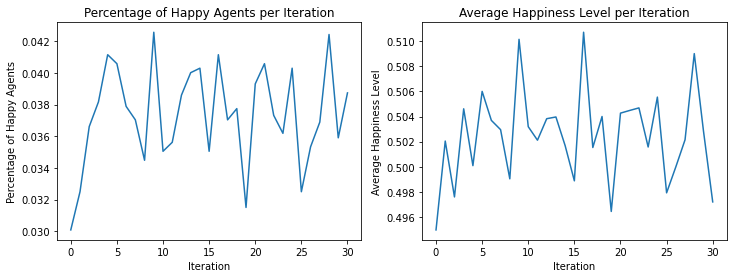

In [17]:
grid_happiness_level, grid_happy_agents = calculate_grid_happiness(grid_history, threshold)

# Plot the happiness level and the percentage of happy agents.
interations = list(range(len(grid_happiness_level)))
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(interations,grid_happy_agents)
axs[0].set_title('Percentage of Happy Agents per Iteration')
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Percentage of Happy Agents")

axs[1].plot(interations,grid_happiness_level)
axs[1].set_title('Average Happiness Level per Iteration')
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Average Happiness Level")

plt.show()

## Recommended Readings

Once you have completed the interaction portion of the module, please read the following recommended reading.

- Chapter 2 - Simple Rules, Pages 46 - 45. Tranquillo, J. V. (2019). An introduction to complex systems: Making sense of a changing world. Springer. https://mcgill.on.worldcat.org/oclc/1087498746

## Optional Readings

Below you will find additional resources in case you would like to continue exploring the topics covered in this module.

- Chapter 4 - Networks and Their Surrounding Contexts, Pages 96-103. Easley, D., & Kleinberg, J. (2012). Networks, crowds, and markets: Reasoning about a highly connected world. Cambridge University Press. https://www.cs.cornell.edu/home/kleinber/networks-book/networks-book-ch04.pdf